In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')

In [2]:
import dizx
from dizx import Edge
from dizx import clifford_simplifier as simp
Phase = dizx.CliffordPhase
d = 3
Z = dizx.VertexType.Z
X = dizx.VertexType.X

In [ ]:
from sympy import symbols
a = symbols("a")
ainv = symbols("ainv")
b = symbols("b")
binv = symbols("binv")
Hadj = dizx.gates.HAD(0,adjoint=True)
H = dizx.gates.HAD(0)
S = dizx.gates.S(0)

lhs = dizx.Circuit(qudit_amount=1, dim=3)
lhs += H**-1 + S**-a + H**-1 + S**-ainv + H**-1 + S**(-a*(b+1)) + H


In [3]:
#R28 from supplement
from dizx.circuit.gates import CZ, CX, HAD, S, Z, X

lhs = dizx.Circuit(qudit_amount=2, dim=3)
lhs += CZ(0,1)
lhs += HAD(0)**2 + HAD(1)
lhs += CZ(0,1)
lhs += CX(1,0)
rhs = dizx.Circuit(qudit_amount=2, dim=3)
rhs += HAD(1)
rhs += CZ(0,1) + CX(1,0)
rhs += S(1) + HAD(1)**2 + S(1)
rhs += CX(0,1)**2
rhs += S(1) + Z(1)


In [4]:
c = lhs + rhs.adjoint()
c

Circuit[3](2 qudits, 0 dits, [CZ(0,1), HAD^2(0), HAD(1), CZ(0,1), CX(1,0), Z^-1(1), S^-1(1), CX^-2(0,1), S^-1(1), HAD^-2(1), S^-1(1), CX^-1(1,0), CZ^-1(0,1), HAD^-1(1)] gates)

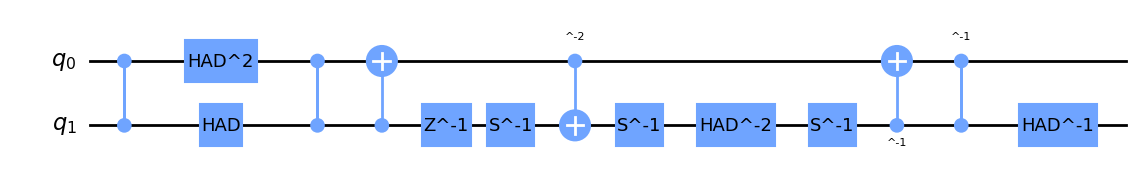

In [5]:
c.to_qiskit_rep().draw("mpl")

In [6]:
cs = simp.CliffordSimplifier(c)
# cs.verbose = True
# print(cs.dag)

In [7]:
cs.simple_optimize()
cs.circuit

Pushing Z^-1(1) through CX^-2(0,1)
Updated the dag, it is now:  CX^-2(0,1)
        S^-1(1)
                HAD^-2(1)
                        S^-1(1)
                                CX^-1(1,0)
                                        CZ^-1(0,1)
                                                HAD^-1(1)

Pushing Z*(1) through CX^-1(1,0)
Updated the dag, it is now:  CX^-1(1,0)
        CZ^-1(0,1)
                HAD^-1(1)

Pushing Z*(1) through CZ^-1(0,1)
Updated the dag, it is now:  CZ^-1(0,1)
        HAD^-1(1)

Pushing Z^-2(0) through CX^-1(1,0)
Updated the dag, it is now:  CX^-1(1,0)
        CZ^-1(0,1)
                HAD^3(1)
                        X^-1(1)

Pushing Z^-2(0) through CZ^-1(0,1)
Updated the dag, it is now:  CZ^-1(0,1)
        HAD^3(1)
                X^-1(1)

Pushing Z^-2(1) through CZ^-1(0,1)
Updated the dag, it is now:  CZ^-1(0,1)
        HAD^3(1)
                X^-1(1)
        Z^-2(0)

Pushing Z(1) through CX^-1(1,0)
Updated the dag, it is now:  CX^-1(1,0)
        CZ^-1

Circuit[3](2 qudits, 0 dits, [CZ(0,1), HAD(1), CZ^-1(0,1), CX^-1(1,0), S^-1(1), CX^2(0,1), CX^-1(1,0), CZ^-1(0,1), HAD^2(0), Z^-2(0), S^-2(1), HAD^5(1)] gates)

In [ ]:
cs = simp.CliffordSimplifier(new_c)
# cs.verbose = True
cs.simple_optimize()
print(cs.dag)

In [ ]:
"hoi"

In [8]:
cs.display_widget()

In [ ]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import HGate, CXGate, CZGate, SWAPGate

qc = QuantumCircuit(2)

# Make labeled gates
h_gate = HGate(label="H^2")
cx_gate = CXGate(label="^{-1}")
cz_gate = CZGate(label="{}^2")

# Append them
qc.append(h_gate, [0])
qc.append(cx_gate, [0, 1])
qc.append(cz_gate,[1,0])

qc.draw("mpl")

In [ ]:
cs.push_CZ_past_CX()

In [ ]:
StepperWidget(cs).show()

In [ ]:
cs.push_CZ_past_CX()

In [ ]:
for circ in cs.circuit_list:
    print(circ)

In [ ]:
cs.euler_decomp()

In [ ]:
cs.euler_decomp2()

In [ ]:
cs.dag